# Initialisation

In [18]:
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnPlannerSys, PosOrnKeypoint
from PyLQR.solver import BatchILQRCP, BatchILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import logging
import sys

from scipy.spatial.transform import Rotation 

from cv_bridge import CvBridge, CvBridgeError

sys.path.append("/home/vdrame/catkin_ws/src/py_panda/PyPanda")
from PyPanda import Robot
from PyPanda import Utils

from utils.camera_utils import RealCamera, RealCameraROS
from utils.transform_utils import *
from utils.iLQR_wrapper import iLQR
from utils.visualisation_utils import depth2pc
from utils.ROS_utils import generate_grasps_client, format_pointcloud_msg, run_action, get_camera_pose, gridRegistrator

import argparse
from scipy.spatial.transform import Rotation

import time

from contact_grasp.srv import contactGraspnetPointcloud2, contactGraspnetPointcloud2Response

import json
import rospy
from cv_bridge import CvBridge, CvBridgeError
from sensor_msgs import point_cloud2
from sensor_msgs.msg import PointField, CameraInfo, Image, PointCloud2
from std_msgs.msg import Header
from geometry_msgs.msg import PoseArray, Pose
import message_filters

import open3d as o3d

# Init communication

In [2]:
bridge = CvBridge()
try:
    rospy.init_node("python_node",anonymous=True)
except:
    print("rospy already initialized")

# dispose_pos = np.array([0.1, 0.66, 0.1])
# dispose_orn_wxyz = np.array([0, 1, 0.35, 0])

# Load robot
rbt = Robot("panda", use_gripper=True)
traj_gen = iLQR(rbt)

image_sub = message_filters.Subscriber("/grid_generator/disposability_grid", Image)
pose_sub = message_filters.Subscriber("/grid_generator/Posearray_pub", PoseArray)
ts = message_filters.TimeSynchronizer([pose_sub, image_sub], 1)
gridRegistrator = gridRegistrator(rbt)
ts.registerCallback(gridRegistrator.callback)

camera_connexion = "ROS"
if camera_connexion == "ROS":
    camera = RealCameraROS()
    intrinsic, distortion = camera.getIntrinsic()
elif camera_connexion == "pyWrapper":
    camera = RealCamera()
    camera.start()
    #retrieve image and depth to initialise camera, otherwise image is very dark
    for i in range(15):
        rgb, depth_image, depth_scale = camera.get_rgb_depth()
else:
    raise Exception("Please choose a valid camera connexion method: ROS or pyWrapper")

[WARN] [1687190445.541175]: No controllers are running


difference between iLQR model ee and real robot ee
quat (zyzw) :[2.6563955e-06 1.8551226e-06 1.2810043e-06 1.0000000e+00]
pos:[ 1.74498463e-06 -7.68574182e-07  1.67199927e-06]
Camera topic found


In [19]:
while True:
    try:
        result_msg = rospy.wait_for_message("/aruco_simple/result", Image, timeout=1)
    except rospy.ROSException:
        print("Aruco topic not available")
        break
    
    result = bridge.imgmsg_to_cv2(result_msg, desired_encoding="passthrough")
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imshow("result", result)
    grid_detection_reference = get_camera_pose(rbt, ee_depth=-0.1150)
    cell_pos, cell_idx = gridRegistrator.get_first_free_cell()
    if cell_pos is None:
        print("No free cell")
    else:
        # cell_pos = cell_pose.position
        dispose_pos = cell_pos
        dispose_orn_wxyz = np.array([0, 1, 0.35, 0])
        try:
            result_msg = rospy.wait_for_message("/grid_generator/result", Image, timeout=1)
            result = bridge.imgmsg_to_cv2(result_msg, desired_encoding="passthrough")
            result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        except:
            print("no grid generator image received")
        cv2.imshow("result", result)
        key = cv2.waitKey(0)
        if key == ord("r"):
            continue
        cv2.destroyAllWindows()
        break

    key = cv2.waitKey(25)
    if key == ord("q"):
        cv2.destroyAllWindows()
        break


TypeError: get_first_free_cell() missing 1 required positional argument: 'self'

# Function

In [ ]:
def restart_controller(homing=False):
    eef_pos, eef_quat = [], []
    rbt.stop_controller()
    rbt.error_recovery()
    rbt.switch_controller("joint_velocity_controller")
    if homing:
        rbt.gripper.homing()

# Grasping

In [28]:
#load pos and orn from json file
with open('config/views_pos.json') as json_file:
    views_pos = json.load(json_file)
    
restart_controller(homing=True)

[WARN] [1687191138.850446]: No controllers are running


In [30]:

pos_dif = 1000
keys = views_pos.keys()
angle_range = [-140, 40]
pc_fused = []
pc_colors_fused = []
reference_pose = np.eye(4)

for view_idx, key in enumerate(keys):
# while (not detected or not detected_with_collision):
    horizon = 30
    if abs(np.sum(np.array(rbt.model.ee_pos_rel()) - np.array(views_pos[key]["pos"]))) > 0.01:
        view_jpos, view_x_pos, view_U, view_Ks, view_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, views_pos[key]["pos"], views_pos[key]["orn_wxyz"], horizon)

        if pos_dif > 0.035:
            print("Trajectory could not reach view continue to next view")
            continue

        view_U = np.array(view_U)
        success, idx, eef_pos, eef_quat = run_action(rbt, view_U, 20)
        rbt.active_controller.send_command(np.zeros(7))
        time.sleep(0.075)
    else:
        print( np.sum(np.array(rbt.model.ee_pos_rel()) - np.array(views_pos[key]["pos"])))
        print(np.array(views_pos[key]["pos"]))
        print(key)
    
    rbg_cv, depth_cv, depth_scale = camera.get_rgb_depth()
    depth_cv = depth_cv * depth_scale
 
    current_pose = get_camera_pose(rbt, ee_depth=-0.110)

    if view_idx == 0:
        init_pos = rbt.model.ee_pos_rel()
        init_orn_wxyz = rbt.model.ee_orn_rel()
        reference_pose = get_camera_pose(rbt, ee_depth=-0.10340)
        depth_init = depth_cv
        rgb_init = rbg_cv
        pc_fused, pc_colors_fused = depth2pc(depth_init, intrinsic, rgb_init)
        pc_fused, pc_colors_fused = regularize_pc(pc_fused, pc_colors_fused, 
                                                  downsampling_method="voxel", voxel_size=0.005,
                                                  outlier_filtering_method="radius", radius_param_arg=[25, 0.015])
    else:
        pc_fused, pc_colors_fused = add_view2pc(pc_fused, pc_colors_fused, reference_pose, current_pose, new_gbr=rbg_cv, 
                                                new_depth=depth_cv, cam_intrisic=intrinsic, regularize=True, voxel_size=0.005)
    pc2_msg = format_pointcloud_msg(pc_fused, pc_colors_fused)
    bgr = cv2.cvtColor(rgb_init, cv2.COLOR_RGB2BGR)
    bgr_msg = bridge.cv2_to_imgmsg(rgb_init, encoding="bgr8")

    orn, pos, opening, score, detected, detected_with_collision = generate_grasps_client(pc2_msg, bgr_msg)

    if (detected or detected_with_collision) and opening > 0.03:
        grasp_pos_world, grasps_orn_world_xyzw = poseCam2World(pos, orn, reference_pose)      
        grasps_orn_world_xyzw = correct_angle(grasps_orn_world_xyzw, angle_range)
        grasp_orn_world_wxyz = convert_quat(grasps_orn_world_xyzw, to="wxyz")
        print("--------------------------------------------------------------------------")
        print("\n\ngrasps in world frame :\n pos :", grasp_pos_world, "\n grasps_orn_world :", grasps_orn_world_xyzw, "\ngrasp world rot",  Rotation.from_quat(grasps_orn_world_xyzw).as_euler("XYZ", degrees=True))
        print("------------------------------------ --------------------------------------")
        break
    break

-0.0020722186100048945
[0.19946612 0.28076629 0.57821704]
view0
Downsampling time: 2.008291244506836s, Filtering time: 0.10247802734375s
calling service


# trajectory

In [14]:
cell_pos, cell_idx = gridRegistrator.get_first_free_cell()
if cell_pos is None:
    print("No free cell")
else:
    # cell_pos = cell_pose.position
    print(gridRegistrator.get_disposability_grid())
    dispose_pos = cell_pos + np.array([0., 0., 0.05])
    dispose_orn_wxyz = np.array([0, 1, 0.35, 0])

[[  0   0 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255   0]]


1000
0.03232206755237734
0.03232206755237734


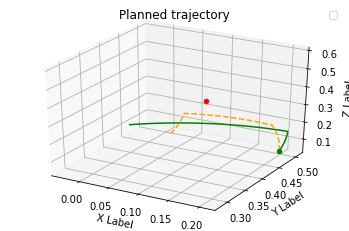

In [15]:
grasp_horizon = 60
grasp_jpos, grasp_x_pos, grasp_U, grasp_Ks, grasp_ds, pos_dif, orn_dif = traj_gen.grasping_trajectory(rbt.q, rbt.dq, grasp_pos_world, grasp_orn_world_wxyz, grasp_horizon)
pos_threshold = 0.015
if pos_dif > pos_threshold:
    print("grasp trajectory error please change viewpose")
grasp_q = grasp_jpos[-1]
grasp_dq = np.zeros_like(grasp_q)
dispose_jpos, dispose_x_pos, dispose_U, dispose_Ks, dispose_ds, pos_dif, orn_dif = traj_gen.dispose_trajectory(grasp_q, grasp_dq, grasp_pos_world, grasp_orn_world_wxyz, dispose_pos, dispose_orn_wxyz, 120)
iLQR.plot_trajectory(init_pos, grasp_pos_world, grasp_x_pos, dispose_x_pos)


In [16]:
# Move to the grasp pose
if opening + 0.015 <= 0.08:
    rbt.gripper.move(width=opening + 0.015)
else:
    rbt.gripper.move(width=0.08)

# Grasp the object
grasp_U = np.array(grasp_U)
success, idx, eef_pos, eef_quat = run_action(rbt, grasp_U[:-30], 20)
rbt.active_controller.send_command(np.zeros(7))
time.sleep(1)
success, idx, eef_pos, eef_quat = run_action(rbt, grasp_U[-30:], 20)
rbt.active_controller.send_command(np.zeros(7))
rbt.gripper.move(width=opening-0.015)


True

In [10]:

# Dispose the object
dispose_U = np.array(dispose_U)
success, idx, eef_pos, eef_quat = run_action(rbt, dispose_U, 20)
rbt.active_controller.send_command(np.zeros(7))
rbt.gripper.stop()
rbt.gripper.move(width=0.082)

# Register the object in the grid
gridRegistrator.set_cell_occupancy(cell_idx, 0)

True

In [17]:
return_horizon = 45
return_jpos, return_x_pos, return_U, return_Ks, return_ds, pos_dif, orn_dif = traj_gen.return_trajectory(rbt.q, rbt.dq, dispose_pos, dispose_orn_wxyz, init_pos, init_orn_wxyz, return_horizon)
return_U = np.array(return_U)
success, idx, eef_pos, eef_quat = run_action(rbt, return_U, 20)
rbt.active_controller.send_command(np.zeros(7))

In [ ]:
restart_controller()

In [ ]:
rbt.stop_controller()

# Miscellaneous

## Get end effector pos

In [ ]:
print("rbt end effector pos:", rbt.model.ee_pos_rel())
print("rbt end effector quat (wxyz):", rbt.model.ee_orn_rel())
print("eef rot",  Rotation.from_quat(convert_quat(rbt.model.ee_orn_rel(), to="xyzw")).as_euler("xyz", degrees=True))


## Show pc with open3d

In [ ]:
import open3d as o3d
pc_o3d = o3d.geometry.PointCloud()
pc_o3d.points = o3d.utility.Vector3dVector(pc_fused)
pc_o3d.colors = o3d.utility.Vector3dVector(pc_colors_fused/255)
coordinate = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
coordinate.translate([0,0 , 0.4])
o3d.visualization.draw_geometries([coordinate, pc_o3d])